# Rede Neural para classificar como Gato ou Cachorro
* treinamento usando dados na memóeria
* treinamento usando flow_from_directory
* treinamento a partir de redes treinadas e modificadas

In [6]:
from rubia_cnn import *
from stridednet import *

## Preparação do dataset

In [2]:
# let's split our dataset in 3 groups of random images, then copy every file to the corresponding folder
#   goal: flow_from_directory showcase

import shutil

path = '/home/lazarop/Downloads/dogs-vs-cats/train/'
dest = '/home/lazarop/Downloads/dogs-vs-cats/subset/'

width, height, depth = 80, 80, 3

def createData(path, dest, save=False):
    if save:
        cleanAug(dest)
    files = []
    for p in os.listdir(path):
        files.append(p)
    df = pd.DataFrame({'images':files})
    df['class'] = df.images.apply(lambda x: x.split('.')[0])
    df['decil'] = df.images.apply(lambda x: int(x.split('.')[1][-1]))
    df['group'] = df.decil.apply(lambda x: 'train' if x < 2 else 'test' if x < 3 else 'validation' if x < 4 else 'skip')
    print(df.groupby(['class', 'group']).count()['images'])
    for _, row in df.loc[df.group!='skip'].iterrows():
        #print(path + row['images'], dest + row['group'] + '/' + row['images'])
        if save: 
            shutil.copy2(path + row['images'], dest + row['group'] + '/' + row['class'] + '/' + row['images'])
        pass
            
def cleanAug(dest):
    for sub in ['train','test','validation']:
        for cl in ['dog','cat']:
            newp = dest + sub + '/' + cl + '/'
            try:
                os.makedirs(newp)
            except:
                for item in os.listdir(newp):
                    os.remove(newp + item)        
        
createData(path, dest, save=False)

class  group     
cat    skip          7500
       test          1250
       train         2500
       validation    1250
dog    skip          7500
       test          1250
       train         2500
       validation    1250
Name: images, dtype: int64


## Treinamento de uma StridedNet sem uso do flow_from_directory nem datagen

In [4]:
main_dir = '/home/lazarop/Downloads/dogs-vs-cats/subset/'

train_dir = "train/"
validation_dir = "validation/"
test_dir = "test/"

X_train, X_validation, X_test = [], [], []
y_train, y_validation, y_test = [], [], []

convert = lambda category : int(category == 'dog')

def createData(opath, width, height, depth):
    X, y = [], []
    for c in os.listdir(opath):
        path = opath + c + '/'
        for p in os.listdir(path):
            category = p.split(".")[0]
            category = convert(category)
            img_array = cv2.imread(os.path.join(path, p))
            new_img_array = cv2.resize(img_array, dsize=(width, height))
            X.append(new_img_array)
            y.append(category)
    X = np.array(X).reshape(-1, width, height, depth)
    y = np.array(y)
    print('Memory ready: X shape %s | y shape %s)' % (str(X.shape), str(y.shape)))
    return X, y


X_train, y_train = createData(os.path.join(main_dir, train_dir), 80, 80, 3)
X_validation, y_validation = createData(os.path.join(main_dir, validation_dir), 80, 80, 3)
X_test, y_test = createData(os.path.join(main_dir, test_dir), 80, 80, 3)

Memory ready: X shape (5000, 80, 80, 3) | y shape (5000,))
Memory ready: X shape (2500, 80, 80, 3) | y shape (2500,))
Memory ready: X shape (2500, 80, 80, 3) | y shape (2500,))



Performance (train/test): 0.95 / 0.77


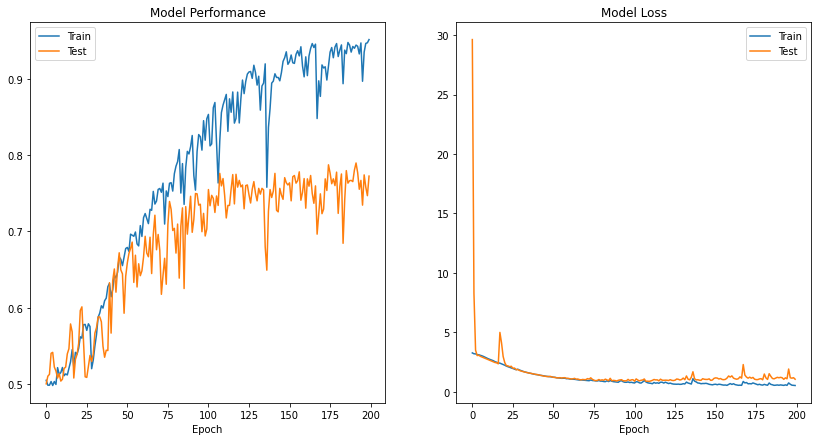


Model evaluation


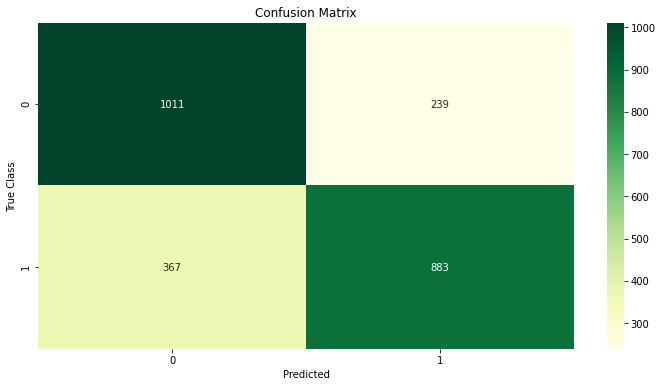

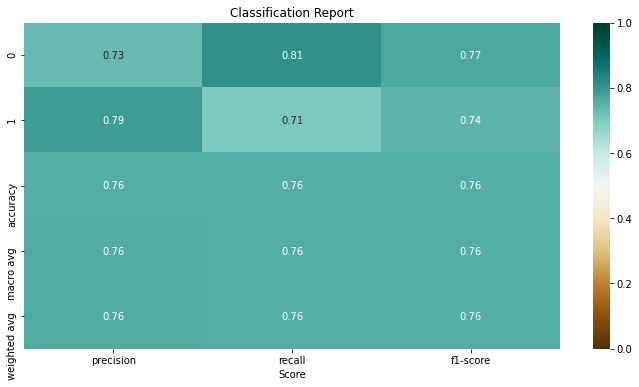

ACCURACY:  75.8 %


In [5]:
gpu = True
workers = 10
epochs = 200
batch_size = 128

k = cnn_keras(X=None, y=None, gpu=gpu, workers=workers)

opt = Adam(lr=1e-3, decay=1e-3/epochs)
reg = l2(0.0005)

model = StridedNetSix.build(width=width, height=height, depth=depth, 
                            classes=1, reg=reg, last_act='sigmoid')
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
#model.summary()

print('\nTraining started:')
start = time.time()
history = model.fit(X_train, y_train, epochs=epochs, verbose=0, batch_size=batch_size,
                    validation_data=(X_validation, y_validation), callbacks=[formatCallbackNotebook(epochs,start)], 
                    workers=k.workers, use_multiprocessing=k.multicore)
k.printHistory(history.history, metric='accuracy')

print('\nModel evaluation')
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
k.printPerformanceC(X_test, y_test, model=model)

## Passando dados usando o método flow_from_directory
* Não é necessário conversões prévias dos dados
* ImageDataGenerator (Keras)

In [3]:
batch_size = 32

datagen = ImageDataGenerator()

# load and iterate training dataset
train_it = datagen.flow_from_directory(dest + 'train/', 
                                       target_size=(width, height), class_mode='binary', batch_size=batch_size)

val_it = datagen.flow_from_directory(dest + 'validation/', 
                                     target_size=(width, height), class_mode='binary', batch_size=batch_size)

test_it = datagen.flow_from_directory(dest + 'test/', 
                                      target_size=(width, height), class_mode='binary', batch_size=batch_size)

Found 5000 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


## Confirmando que o iterador funciona

In [4]:
#batchX, batchy = train_it.next()
#print('BatchX shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))
#print('Batchy shape=%s, min=%.3f, max=%.3f' % (batchy.shape, batchy.min(), batchy.max()))

## Treinamento usando uma StridedNet e flow_from_directory


Performance (train/test): 0.93 / 0.85


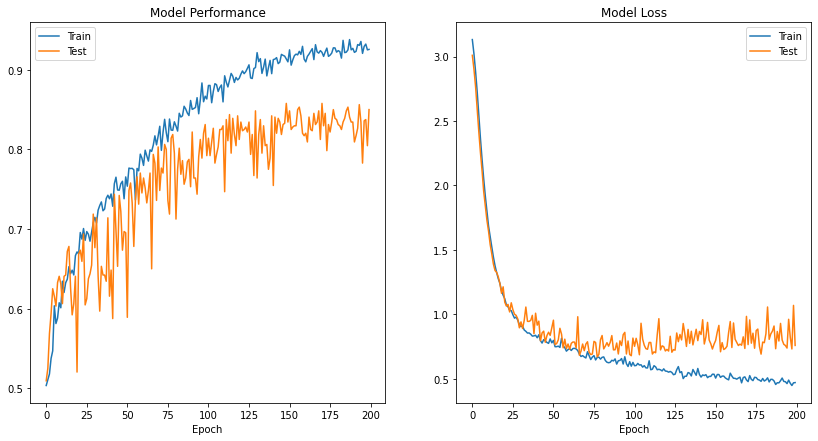


Model evaluation
  ...
    to  
  ['...']
Performance: 0.8332 0.8701311779927604


In [24]:
gpu = True
workers = 10
epochs = 200

k = cnn_keras(X=None, y=None, gpu=gpu, workers=workers)

opt = Adam(lr=1e-3, decay=1e-3/epochs)
reg = l2(0.0005)

model = StridedNetSix.build(width=width, height=height, depth=depth, 
                            classes=1, reg=reg, last_act='sigmoid')
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
#model.summary()

print('\nTraining started:')
start = time.time()
history = model.fit(train_it, epochs=epochs, steps_per_epoch=100, verbose=0, 
                    validation_data=val_it, validation_steps=20, callbacks=[formatCallbackNotebook(epochs,start)], 
                    workers=k.workers, use_multiprocessing=k.multicore)
k.printHistory(history.history, metric='accuracy')

print('\nModel evaluation')
test_loss, test_acc = model.evaluate(test_it, verbose=0)
print('Performance:', test_acc, test_loss)

## Treinamento usando uma MaxPooledNet e flow_from_directory


Performance (train/test): 1.00 / 0.72


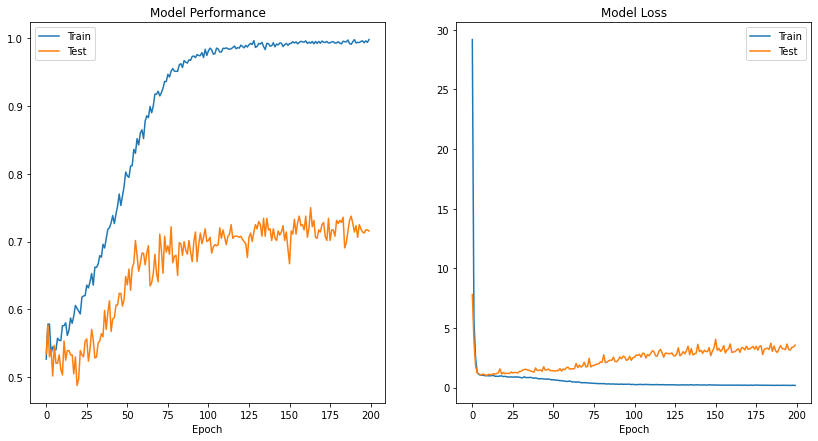


Model evaluation
  ...
    to  
  ['...']
Performance: 0.7004 3.41750904427299


In [25]:
gpu = True
workers = 10
epochs = 200

k = cnn_keras(X=None, y=None, gpu=gpu, workers=workers)

opt = RMSprop(lr=1e-4)
reg = l2(0.0005)

model = PooledThree.build(width=width, height=height, depth=depth, 
                            classes=1, reg=reg)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
#model.summary()

print('\nTraining started:')
start = time.time()
history = model.fit(train_it, epochs=epochs, steps_per_epoch=100, verbose=0, 
                    validation_data=val_it, validation_steps=20, callbacks=[formatCallbackNotebook(epochs,start)],
                    workers=k.workers, use_multiprocessing=k.multicore)
k.printHistory(history.history, metric='accuracy')

print('\nModel evaluation')
test_loss, test_acc = model.evaluate(test_it, verbose=0)
print('Performance:', test_acc, test_loss)

# Data Augmentation
* Recurso para aumentar quantidade de amostras

## Gerando novas imagens a partir do objeto data_generator do keras

In [27]:
datagen = ImageDataGenerator(
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img(path + 'cat.1062.jpg') 
x = img_to_array(img)  
x = x.reshape((1,) + x.shape)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
N = 5
for batch in datagen.flow(x, batch_size=1, save_to_dir=dest+'preview/', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > N:
        break  # Recurso de parada do gerador

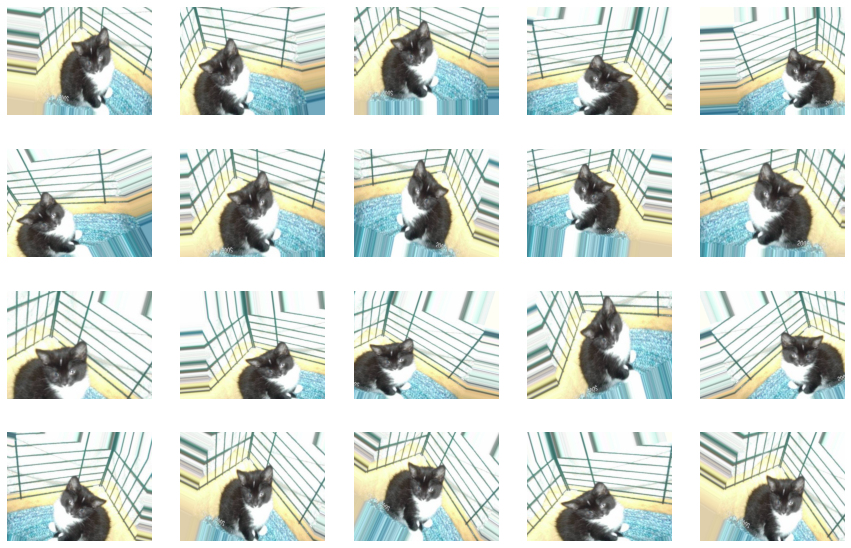

In [30]:
from numpy import expand_dims

datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2, 
                             rotation_range=30, horizontal_flip=True)

data = img_to_array(img)
samples = expand_dims(data, 0)
it = datagen.flow(samples, batch_size=1)

fig, axs = plt.subplots(nrows=4, ncols=5, figsize = (15, 10))
for i in range(20):
    batch = it.next()
    image = batch[0].astype('uint8')
    axs.flatten()[i].imshow(image)
    axs.flatten()[i].set_axis_off()
plt.show()

## Treinamento de uma StridedNet usando datagen+flow_from_directory

In [8]:
batch_size = 50

datagen = ImageDataGenerator()

val_it = datagen.flow_from_directory(dest + 'validation/', 
                                     target_size=(width, height), class_mode='binary', batch_size=batch_size)

test_it = datagen.flow_from_directory(dest + 'test/', 
                                      target_size=(width, height), class_mode='binary', batch_size=batch_size)

train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_it = train_datagen.flow_from_directory(dest + 'train/', target_size=(width, height), class_mode='binary', 
                                             color_mode="rgb", batch_size=2*batch_size, shuffle=True)

Found 2500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.



Performance (train/test): 0.84 / 0.78


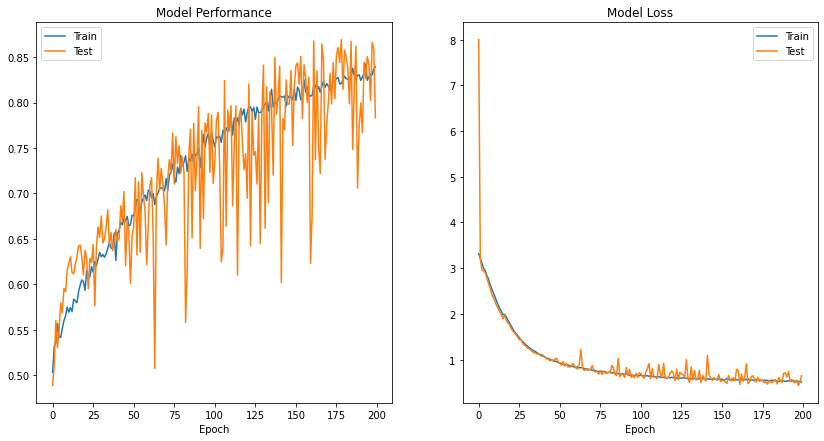


Model evaluation
  ...
    to  
  ['...']
Performance: 0.782 0.6423232328891754


In [4]:
gpu = True
workers = 10
epochs = 200

k = cnn_keras(X=None, y=None, gpu=gpu, workers=workers)

opt = Adam(lr=1e-3, decay=1e-3/epochs)
reg = l2(0.0005)

model = StridedNetSix.build(width=width, height=height, depth=depth, 
                            classes=1, reg=reg, last_act='sigmoid')
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
#model.summary()

print('\nTraining started:')
start = time.time()
history = model.fit(train_it, epochs=epochs, steps_per_epoch=50, verbose=0, 
                    validation_data=val_it, validation_steps=50, callbacks=[formatCallbackNotebook(epochs,start)], 
                    workers=k.workers, use_multiprocessing=k.multicore)
k.printHistory(history.history, metric='accuracy')

print('\nModel evaluation')
test_loss, test_acc = model.evaluate(test_it, verbose=0)
print('Performance:', test_acc, test_loss)

## Reutilizando um modelo treinado para treinar apenas a última camada
* Removendo a última camada e subsituindo por outra

In [7]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

vgg162 = VGG16(weights='imagenet', include_top=True)
vgg162.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [8]:
# Generate a model with all layers (with top)
base = VGG16(weights='imagenet', include_top=True)

for layer in base.layers:
    layer.trainable = False
    #print(layer)

#Add a layer where input is the output of the  second last layer 
inputs = base.layers[-2].output
model = Dense(1, activation='sigmoid', name='predictionsDG')(inputs)

#Then create the corresponding model 
model = Model(inputs=base.input, outputs=model)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
main_dir = '/home/lazarop/Downloads/dogs-vs-cats/subset/'

train_dir = "train/"
validation_dir = "validation/"
test_dir = "test/"

X_train, X_validation, X_test = [], [], []
y_train, y_validation, y_test = [], [], []

convert = lambda category : int(category == 'dog')

def createData(opath, width, height, depth):
    X, y = [], []
    for c in os.listdir(opath):
        path = opath + c + '/'
        for p in os.listdir(path):
            category = p.split(".")[0]
            category = convert(category)
            img_array = cv2.imread(os.path.join(path, p))
            new_img_array = cv2.resize(img_array, dsize=(width, height))
            X.append(new_img_array)
            y.append(category)
    X = np.array(X).reshape(-1, width, height, depth)
    y = np.array(y)
    print('Memory ready: X shape %s | y shape %s)' % (str(X.shape), str(y.shape)))
    return X, y
    

X_train, y_train = createData(os.path.join(main_dir, train_dir), 224, 224, 3)
X_validation, y_validation = createData(os.path.join(main_dir, validation_dir), 224, 224, 3)
X_test, y_test = createData(os.path.join(main_dir, test_dir), 224, 224, 3)

Memory ready: X shape (5000, 224, 224, 3) | y shape (5000,))
Memory ready: X shape (2500, 224, 224, 3) | y shape (2500,))
Memory ready: X shape (2500, 224, 224, 3) | y shape (2500,))



Performance (train/test): 1.00 / 0.98


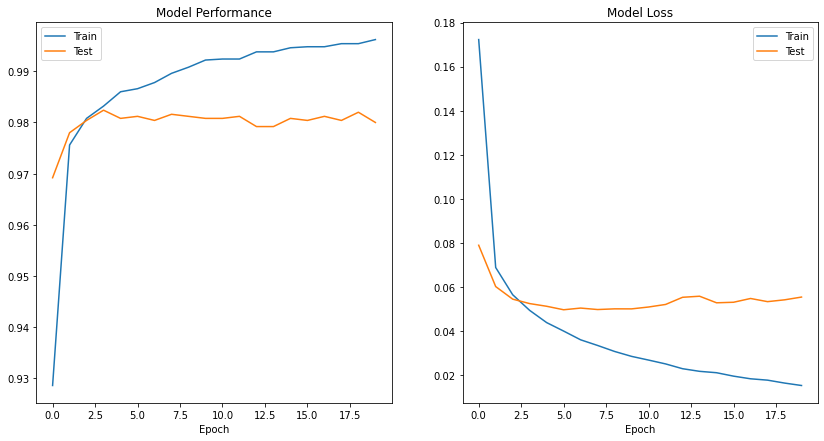

In [9]:
gpu = True
workers = 10
epochs = 20
batch_size = 16

k = cnn_keras(X=None, y=None, gpu=gpu, workers=workers)

opt = RMSprop(lr=1e-4)

model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
#model.summary()

print('\nTraining started:')
start = time.time()
history = model.fit(X_train, y_train, epochs=epochs, verbose=0, batch_size=batch_size,
                    validation_data=(X_validation, y_validation), callbacks=[formatCallbackNotebook(epochs,start)], 
                    workers=k.workers, use_multiprocessing=k.multicore)
k.printHistory(history.history, metric='accuracy')

In [11]:
print('\nModel evaluation')
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0, batch_size=batch_size)
print('Performance:', test_acc, test_loss)


Model evaluation
Performance: 0.9772 0.08618998711655156


## Mesmo exercício - Usando a rede treinada InceptionV3

In [2]:
main_dir = '/home/lazarop/Downloads/dogs-vs-cats/subset/'

train_dir = "train/"
validation_dir = "validation/"
test_dir = "test/"

X_train, X_validation, X_test = [], [], []
y_train, y_validation, y_test = [], [], []

convert = lambda category : int(category == 'dog')

def createData(opath, width, height, depth):
    X, y = [], []
    for c in os.listdir(opath):
        path = opath + c + '/'
        for p in os.listdir(path):
            category = p.split(".")[0]
            category = convert(category)
            img_array = cv2.imread(os.path.join(path, p))
            new_img_array = cv2.resize(img_array, dsize=(width, height))
            new_img_array = new_img_array / 255.
            X.append(new_img_array)
            y.append(category)
    X = np.array(X).reshape(-1, width, height, depth)
    y = np.array(y)
    print('Memory ready: X shape %s | y shape %s)' % (str(X.shape), str(y.shape)))
    return X, y
    

X_train, y_train = createData(os.path.join(main_dir, train_dir), 150, 150, 3)
X_validation, y_validation = createData(os.path.join(main_dir, validation_dir), 150, 150, 3)
X_test, y_test = createData(os.path.join(main_dir, test_dir), 150, 150, 3)

Memory ready: X shape (5000, 150, 150, 3) | y shape (5000,))
Memory ready: X shape (2500, 150, 150, 3) | y shape (2500,))
Memory ready: X shape (2500, 150, 150, 3) | y shape (2500,))


In [4]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

baseModel = InceptionV3(weights="imagenet", include_top=False)

for layer in baseModel.layers:
    layer.trainable = False

x = baseModel.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout (0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout (0.5)(x)
x = Dense(32, activation='relu')(x)
model = Dense(1, activation='sigmoid')(x)

model = Model(inputs=baseModel.input, outputs=model)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
______________________________________________________________________________________________


Performance (train/test): 0.83 / 0.94


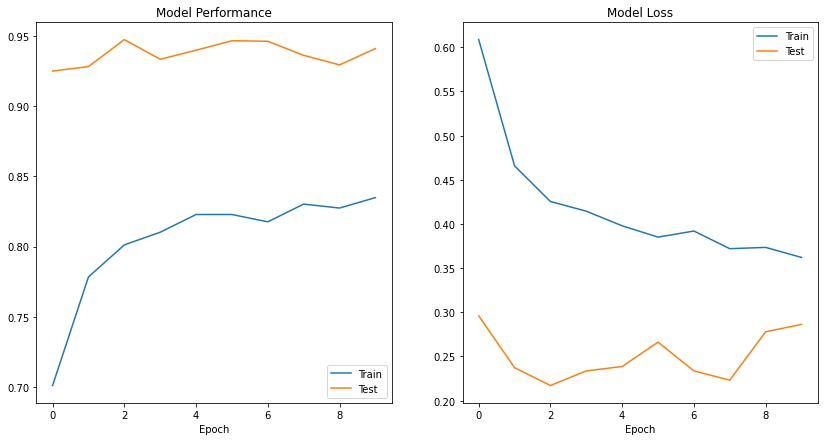


Model evaluation
Performance: 0.9332 0.33922760921396256


In [5]:
gpu = True
workers = 10
epochs = 10
batch_size = 16

k = cnn_keras(X=None, y=None, gpu=gpu, workers=workers)

opt = RMSprop(lr=1e-4)
opt = Adam(lr=1e-3, decay=1e-3/epochs)

model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
#model.summary()

print('\nTraining started:')
start = time.time()
history = model.fit(X_train, y_train, epochs=epochs, verbose=0, batch_size=batch_size,
                    validation_data=(X_validation, y_validation), callbacks=[formatCallbackNotebook(epochs,start)], 
                    workers=k.workers, use_multiprocessing=k.multicore)
k.printHistory(history.history, metric='accuracy')

print('\nModel evaluation')
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Performance:', test_acc, test_loss)

## Inspecionando convnets


(1, 80, 80, 3)


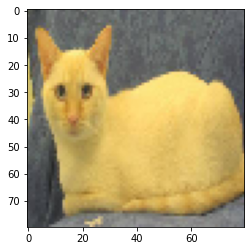

In [10]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import tensorflow.keras.preprocessing.image as image

import numpy as np
import matplotlib.pyplot as plt

main_dir = '/home/lazarop/Downloads/dogs-vs-cats/train/'
img_path = main_dir + 'cat.1108.jpg'

img = image.load_img(img_path, target_size=(80, 80)) 
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0) 
img_tensor /= 255.

print(img_tensor.shape)
plt.imshow(img_tensor[0])
plt.show()

In [8]:
model = PooledThree.build(width=80, height=80, depth=3, classes=1, reg=l2(0.0005))

In [13]:
layer_outputs = [layer.output for layer in model.layers[:8]] 
#print(layer_outputs)

activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]

print(first_layer_activation.shape)

(1, 78, 78, 32)


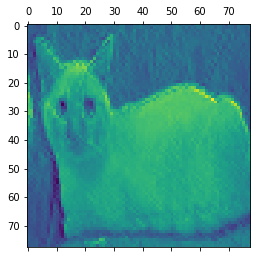

In [14]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')
plt.show()

/home/lazarop/miniconda3/envs/tfgpu/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


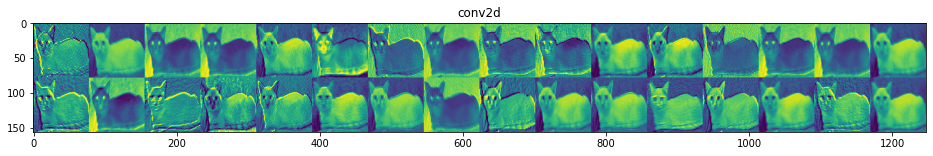

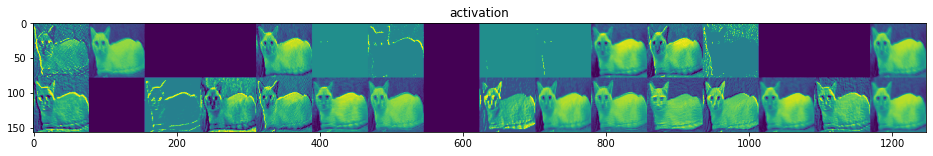

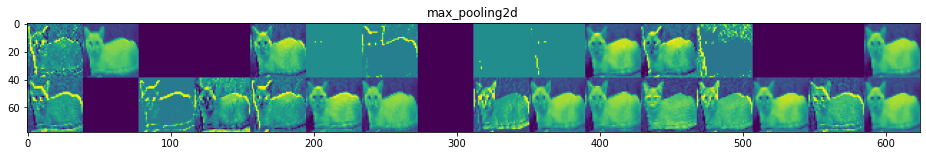

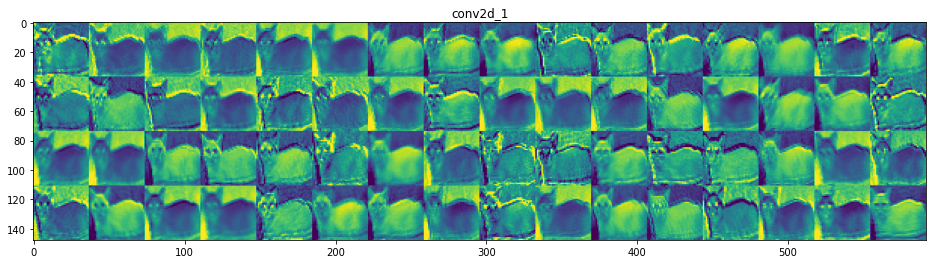

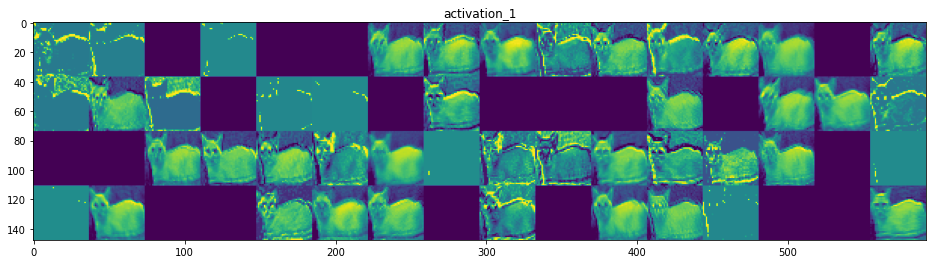

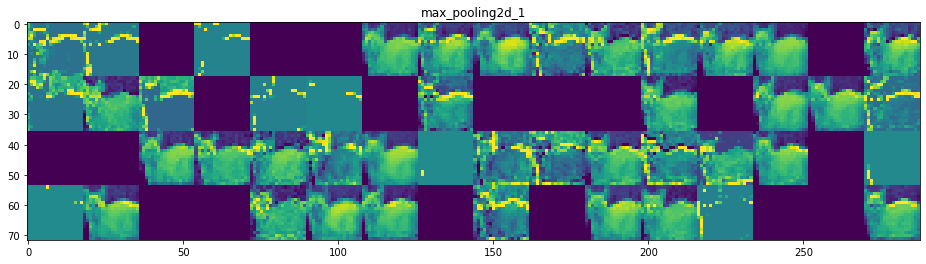

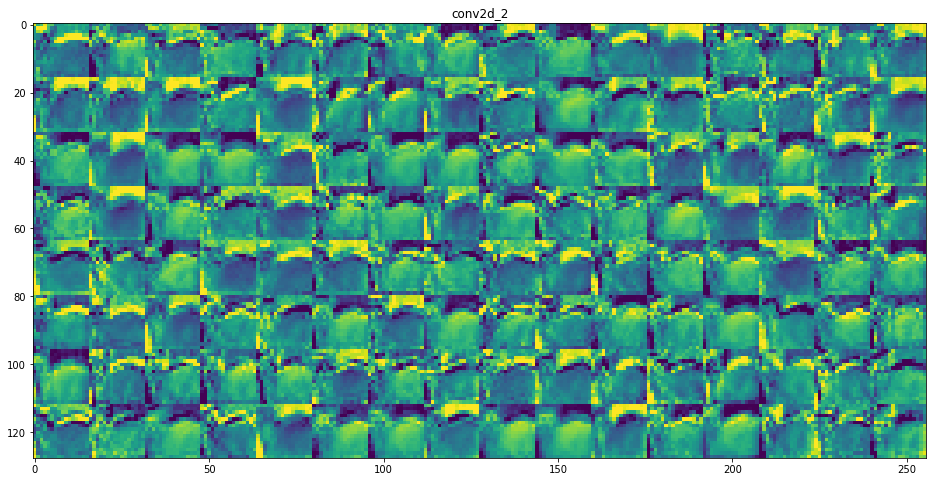

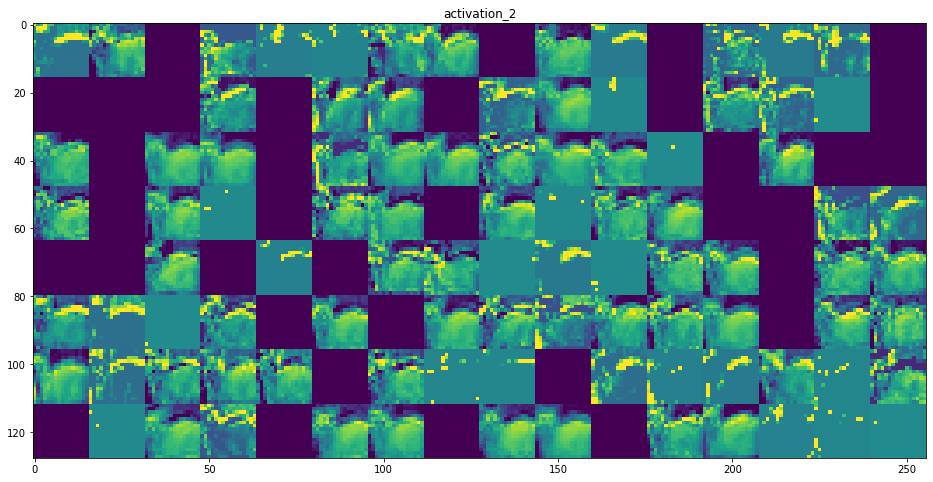

In [16]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):

    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]

    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
  
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()